# Wetland water depth outputs<img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` and `DEA Sandbox` environment 
* **Products used:** 
* **Special requirements:** 
* **Prerequisites:** This notebook assumes you have previously run the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook and saved out a netCDF file containing all the variables at the end of the notebook. A csv file containing the daily maximum water discharge of a relevant stream gauge is also required. The gauge data can be downloaded via the Bureau of Meteorology's [Water Data Online](http://www.bom.gov.au/waterdata/) portal.

## Background
The Commonwealth Environmental Water Office (CEWO) is obliged to act in accordance with the Water Act and the Basin Plan.  This requires Basin water resources to be managed in a way that gives effect to relevant international agreements (to the extent to which those agreements are relevant to the use and management of the Basin water resources). The Basin Plan has a specific objective to protect and restore a subset of all water-dependent ecosystems of the Murray-Darling Bain including by ensuring that: 
* Declared Ramsar wetlands that depend on Basin water resources maintain their ecological character. 

## Description
This notebook produces the following deliverables for each Ramsar site for each 10 year time period: 

* Maps in the form of .jpg, polygons and rasters showing: (these maps should also include key vegetation types, including open water, as provided by the CEWO and also the Ramsar site boundary.)
    1. Inundation extent for each month across the time period. (This could be presented so that you can slide along a hydrograph and see the resultant inundation extent on a map below. This should also identify key vegetation types. 
    2. Inundation extent for each vegetation type for each event (an event comprises the time between commencement of inundation of the vegetation type and conclusion of inundation of the vegetation type i.e. vegetation type completely dry) across the period event for critical durations (1, 3, 5, 7, >9 months)(these inundation extents are critical for different types of vegetation) 
        * Derived from remote sensing <img align='right' src="./InputData/TOR-AttachmentA.png" style="width: 400px;"/>
        2.a. Comparison of remotely sensed data with ground-truthed data and OEH datasets (NSW only). 
    3. Maps of depth for critical durations, only if DEM data is available within GA or supplied by CEWO (1, 3, 5, 7, >9 months)  
    4. Vegetation condition over the entire four year period. 
5. Graph and .csv file of inundation duration for each different vegetation type, for all natural and environmental flows, as per image to the right
6. Table identifying: 
    * % of different vegetation classes inundated for each specified time period for each event and maximum and average depth of inundation.
    * Time between each inundation event for 10%, 25%, 50%, 75% and 100% of each vegetation type 
e.g. 

| Site | Sub-site | Decade | Vegetation Type | % inundated 1 month | % inundated 3 months | % inundated 5 months | % inundated 7 months | % inundated > 9 months | Max depth | Average depth |
|-----|----|----|----|----|----|----|----|----|----|----|
|Banrock Station | | |River redgum | | | | | | |
| | | |Black box | | | | | | |
| | | |Lignum| | | | | | |
| | | |Saltmarsh| | | | | | |
| | | |Tall emergent aquatics| | | | | | |
| | | |Grass/forb | | | | | | |


7. Annual vegetation condition for each Ramsar site for the whole archive period
***

## Table of Contents:
* **[Code Assumptions](#CodeAssumptions)**
    * Some assumptions and decisions made within the code that may affect the results
* **[(Progress Tracking)](#ProgressTracking)**
    * Summary of what data has been processed so far
* **[Getting Started](#GettingStarted)**
    * Load in packages and functions needed for this analysis
* **[Analysis Parameters](#AnalysisParameters)**
    * Variables, datasets and file names used throughout the code. All of the options that can be changed within this code should be changed within these parameters. The rest of the code just runs the analysis, taking in the chosen parameters like event thresholds and output file names.
* **[Load in the pre-analysed datasets](#LoadData)**
    * Load in the datasets we have already produced using the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook. This is a prerequisite for this notebook to run.
* **[Calculate the water level for each inundated area across all time](#CalculateDepthPerTime)**
    * Combine LiDAR data with Landsat surface 'wet' observations to calculate estimated water depth for each Landsat time step.
* **[Identify 'events' within the wetland](#IdentifyEvents)**
    * A csv of events within the wetland is produced and saved out for later use. Check out the [Code Assumptions](#CodeAssumptions) section for some discussion around the definition of an 'event'.
* **[Calculate the per event pixel inundation duration](#InundationDuration)**
    * 
* **[1. Maps of inundation extent across the time period 2014-2019](#InundationExtent)**

<a id='CodeAssumptions'></a>
## Code assumptions

* **Event definition**
    * Events were defined as starting when at least `EventThreshold`(defined below)% of the total wetland area is seen as wet, and ends when no more than `EventThreshold`% of the wetland remains 'wet'. 
    * If the wetland drops below the `EventThreshold` and then back up above it within `CloseEnoughTogether` days, then we combine the two events into a single event. This is done to account for errors introduced by the Landsat 7 SLC-off period, where strips of no-data exist across the scenes. 
    * If the first time a wetland is observed by Landsat 5 (1986/7), the wetland meets the event threshold, we choose NOT to include this event in the list of events
        * We don't know how long the wetland was wet before we first observed it, and so can't provide uncertainties on event duration, so we do not include it in the results
* **Event inundation duration**
    * For analysis of inundation duration WITHIN an event, we assume that if a single pixels wets, dries, wets etc more than once, it's all related to the same wetland-wide event (which is defined above). e.g. If a pixel has a within event inundation history of 5 days wet, then is dry for 5 days, then wet for 45 days, then we consider this pixel to have been wet for 50 days during this event. 
    
1. Maps of inundation extent across the time period 2014-2019
2. Maps of inundation extent for each vegetation type for each event
    a. Comparison of remotely sensed data maps with ground-truthed data and OEH datasets 
3. Maps of depth for critical durations
4. Vegetation condition over the entire four year period
5. Graph and .csv file of inundation duration for each different vegetation type
6. Table identifying % of different vegetation classes inundated for each specified time period for each event and maximum and average depth of inundation and Time between each inundation event for 10%, 25%, 50%, 75% and 100% of each vegetation type
    * We use days to define the requested metric periods, so 1 month = 30 days, 3 months = 90 days etc.
    * Metrics for wet percentage for the 30, 90, 150, 210 and 270 day periods are calculated using >= each period. For example, a pixel that was wet for 110 days during an event will be counted in the 30 and 90 day metrics, but not the 150 day metric. 
    * Results for the duration of different percentages of inundation are presented in days. 
7. Annual vegetation condition for each Ramsar site for the whole archive period

<a id='ProgressTracking'></a>
## (Progress tracking)

| Wetland | LiDAR DEM | Vegetation shapefile | NetCDF created? | Event Area Threshold |
|---------|-----------|----------------------|-----------------|------------------|
| Narran Lake | <ul><li>Data are a combination of [GA's aggregated 5m DEM product](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/89644), and NSW Spatial Services 5m DEM scenes from the couple of bits of the eastern edge of the Ramsar polygon that are cut out of the GA product</li><li>The combination happened by clipping the GA and required additional NSW scenes to the extent of the Ramsar polygon.</li><li> These were then merged together using the `mosaic` tool in ArcGIS, where the GA scene was given preference over the NSW scenes where data existed in both</li></ul>  | `VegShapeFileVegNameColumn = 'AggCOMM'` `VegShapeFileVegNameUIDColumn = None` | Yes | 5% area |
| Gwydir - Crinolyn | [GA's aggregated 5m DEM product](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/89644) | `VegShapeFileVegNameColumn = 'AggComm'` `VegShapeFileVegNameUIDColumn = None` | | 7% area |

***

<a id='GettingStarted'></a>
## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import sys
import glob
import itertools
import xarray as xr
import numpy as np
import pandas as pd
from rasterio import features, transform
import geopandas as gpd
from shapely.geometry import shape as shapelyshape

import pickle
import warnings
warnings.simplefilter("ignore")

### Load functions
These functions are required for the analyses below.

In [2]:
def get_water_level(geom, dem, height_percentile=90, x_offsets=[0], y_offsets=[0]):  
        
    '''
    Takes a shapely geometry (either LineString or MultiLineString) and a Digital Elevation
    Model (DEM), and samples values from the DEM based on line vertices. These values are used
    to return the median and standard deviation of elevation, which can subsequently be used
    to compute volume (and uncertainty) based on the same DEM.
    
    Optionally, this function can be run with a set of x and y offset values, which shuffle 
    the geometry object left, right, up and down, and returns values for the combination 
    with the lowest standard deviation. This is intended to account for 'jitter' caused by 
    poor co-registration/georeferencing in the Sentinel 2 imagery. This is experimental, and
    should be used with caution.
    
    Last modified: March 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------    
    geom : Shapely LineString or MultiLineString
        Shapely geometry for the waterline being analysed
    dem : array
        A 2D digital elevation model (DEM) in the form of a numpy or xarray array.
    x_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry east and west.
        The default is [0], which does no shuffling. E.g. setting `x_offsets=[-10, 0, 10]`
        will shuffle the geometry west and east by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
    y_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry north and south.
        The default is [0], which does no shuffling. E.g. setting `y_offsets=[-10, 0, 10]`
        will shuffle the geometry north and south by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
        
    Returns
    -------
    offset_min_std : Pandas DataFrame
        A Pandas dataframe with columns giving `x_offset', 'y_offset`, `water_level` and 
        `water_level_std` values. `x_offset', 'y_offset` give the offset values which resulted
        in the lowest standard deviation of elevation values, while `water_level` and 
        `water_level_std` return the corresponding median and standard deviation elevation values
        themselves.
    '''
    
    # First try extracting line vertex coordinates from a Shapely LineString
    try: 
        xx, yy = geom.exterior.coords.xy
        xx = np.array(xx)
        yy = np.array(yy)

    # If this fails, extract line vertex coordinates as if data is a Shapely MultiLineString
    except:
        xx = np.concatenate([i.coords.xy[0] for i in geom])
        yy = np.concatenate([i.coords.xy[1] for i in geom]) 
        
    # Convert coordinates to xarray DataArrays to facilitate fast extraction of elevation values
    xx = xr.DataArray(xx, dims='z')
    yy = xr.DataArray(yy, dims='z')
    
    # Iterate through all combinations of x and y offsets
    all_offsets = []    

    for x_offset, y_offset in itertools.product(x_offsets, y_offsets):    
        
         # Sample DEM to extract elevations for each vertex coordinate
        sampled_elevs = dem.interp(x=xx + x_offset, y=yy + y_offset).values

        # Compute median and standard deviation elevation values, and add to list
        all_offsets.append(((x_offset, y_offset, np.nanpercentile(sampled_elevs, height_percentile), np.nanstd(sampled_elevs))))

    # From the dataframe of resulting water_levels and water_level_stds for different xy offsets, 
    # select the row with the lowest standard deviation in elevation values.
    offset_df = pd.DataFrame(all_offsets, columns=['x_offset', 'y_offset', 
                                                   'water_level', 'water_level_std'])

    # Check that we haven't returned all empty data. If we have, it means there was no DEM value for our wet blob
    if np.isfinite(offset_df.water_level_std.idxmin()):
        offset_min_std = offset_df.iloc[offset_df.water_level_std.idxmin()]
    else:
        # if there wasn't valid data calculated, then just return the first row, which will be nan.
        offset_min_std = offset_df.iloc[0]
    return offset_min_std 

<a id='AnalysisParameters'></a>
## Analysis parameters

* `AnalysisLocation`: A string descriptor of the analysis region used to label graphs.
* `StreamGaugeName`: A string name of the stream gauge used in the analysis, used to label graphs.
* `OutSaveLocation`: A string folder structure for the location of files written out by the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook, and this notebook. It makes use of the `AnalysisLocation` string to generate the filepath.

### Files to analyse
* `DatasetToLoad`: The filename of the netCDF written out by the [first notebook](./WetlandWaterDepthAnalyses.ipynb) to read in here. Note that this file must have been written out by the first notebook, as we assume the variables created in that notebook exist here. If you try to read in something else, this code will fail.
* `SpeciesDictToLoad`: The filename of the text file written out by the [first notebook](./WetlandWaterDepthAnalyses.ipynb) that contains the species dictionary of vegetation type and numerical ID. This is used to label plots.
* `StreamGaugeToLoad`: The filename of a csv file containing the daily maximum water discharge of a relevant stream gauge. The gauge data can be downloaded via the Bureau of Meteorology's [Water Data Online](http://www.bom.gov.au/waterdata/) portal. The code below assumes that commented lines begin with `#`. 

### Analysis options
* `HeightPercentile`: e.g. 90. The wetland water depth is calculated by intersecting the outline of wet pixel 'blobs' identified by Landsat with a LiDAR DEM. The values within the DEM are then sampled to determine the water height. This is done by using the `HeightPercentile` percentile of these sampled values. This allows us to discard the hightest DEM pixels, which may result from the mismatch between the Landsat and LiDAR resolutions, e.g. if there is a stream bank in the same cell as the stream, taking a percentile value will help to remove the erroneously high values of the stream bank.
* `EventThreshold`: e.g. 5. Used to determine the threshold for starting/ending a watering event. Watering events are defined as starting when at least `EventThreshold`(defined below)% of the total wetland area is seen as wet, and ends when no more than `EventThreshold`% of the wetland remains 'wet'. If the wetland completely dries out between events, set this threshold low e.g. 5. If the wetland contains refugial pools that rarely dry out, a wet event may need to be defined using a higher threshold. 
* `ShortEventThreshold`: e.g. 30. Number of days an event needs to be less than, to be considered a short event that may need to be combined with the previous or next event. This is particularly important where a wet event is broken by only one observation below the `EventThreshold`, before returning above it. 
* `CloseEnoughTogether`: e.g. 16. Number of days that two separate events need to be separated by before they are combined and considered a single long event. 
* `AreasToCalc`: e.g. [0.1, 0.25, 0.50, 0.75, 0.100]. A list of numbers of the decimal vegetation area thresholds to calculate. E.g. 0.1 will calculate a value for 10% of the vegetation area. These are used in section 6 below.
* `Colormaps`: e.g. ['Blues', 'YlOrBr', 'Greens', 'Purples', 'Reds']. A list of [Matplotlib named colormaps](https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html) to use to plot the different vegetation communities. 

### Output filenames

#### Section 2
* `EventMapsFileName` : e.g. string. File path for the output plots for each wet event. The complete file path is created in the code below, since it adds in the event dates as it plots. 

#### Section 5
* `InundationPctPerVegFigFileName`: e.g. string.jpg Output file name for the all time vegetation community based inundation plot.
* `InundationPctPerVegDataFileName`: e.g. string.csv Output file name for the all time vegetation community based inundation csv.

#### Section 6
* `EventListFileName`: e.g. string.csv Output file name for the start and end dates and duration of each defined watering event.
* `EventInundationTableFileName`: e.g. string.csv Output file name for the event-based inundation % metrics for each vegetation community.
* `EventDurationTableFileName` : e.g. string.csv Output file name for the event-based duration metrics for each vegetation community.

In [113]:
# Note, if your `AnalysisLocation` contains special characters other than spaces, you will
# need to modify the `replace` function used to generate the output file names.
AnalysisLocation = 'Gwydir - Crinolyn'
StreamGaugeName = 'Gingham Channel'
OutSaveLocation = f'OutputData/Gwydir/'

DatasetToLoad = f'{OutSaveLocation}AllDataCombined{AnalysisLocation.replace(" ", "")}.nc'
HighResDatasetToLoad = LidarVegOutputName = f'{OutSaveLocation}LiDARVeg{AnalysisLocation.replace(" ", "")}.nc'
SpeciesDictToLoad = f'{OutSaveLocation}SpeciesDict{AnalysisLocation.replace(" ", "")}.txt'
StreamGaugeToLoad = 'InputData/Gwydir/Gwydir_GinghamChannel_418079DailyMaxMetre.csv'
RamsarBoundaryFile = 'InputData/Gwydir/GwydirCrinolynRamsar.shp'

HeightPercentile = 90

EventThreshold = 7
ShortEventThreshold = 30
CloseEnoughTogether = 16
AreasToCalc = [0.1, 0.25, 0.50, 0.75, 1]
Colormaps = ['Blues', 'YlOrBr', 'Greens', 'Purples', 'Reds', 'Greys']

# Depth netCDF output file name
WetlandWaterDepthsFileName = f'{OutSaveLocation}WetlandWaterDepths{AnalysisLocation.replace(" ", "")}.nc'
WetEventsLinePlot = f'{OutSaveLocation}PercentofWetlandThatsWet{AnalysisLocation.replace(" ", "")}.jpg'
WetEventsHistogram = f'{OutSaveLocation}PercentofWetlandThatsWetHistogram{AnalysisLocation.replace(" ", "")}.jpg'

# Outputs for section 2
EventMapsFileName = f'{OutSaveLocation}EventMaps/{AnalysisLocation}Event' # Name completed and appended in the script below

# Outputs for section 5
InundationPctPerVegFigFileName = f'{OutSaveLocation}InundationPctPerVeg{AnalysisLocation.replace(" ", "")}.jpg'
InundationPctPerVegDataFileName = f'{OutSaveLocation}InundationPctPerVeg{AnalysisLocation.replace(" ", "")}.csv'
# Outputs for section 6
EventListFileName = f'{OutSaveLocation}WetEventsIn{AnalysisLocation.replace(" ", "")}With{str(EventThreshold)}%AreaThreshold.csv'
EventInundationTableFileName = f'{OutSaveLocation}EventInundationMetricsFor{AnalysisLocation.replace(" ", "")}.csv'
EventDurationTableFileName = f'{OutSaveLocation}EventDurationMetricsFor{AnalysisLocation.replace(" ", "")}.csv'
EventResultsPickleFileName = f'{OutSaveLocation}EventResults/' # Name completed and appended in the script below

<a id='LoadData'></a>
## Load in our pre-analysed datasets

### Starting with our giant all together netCDF

In [4]:
AllDataCombined = xr.open_dataset(DatasetToLoad)

We need to create a transform object from our dataset so that we can do some of the code calculations later on.

In [5]:
AllDataCombined.attrs['transform'] = transform.from_bounds(AllDataCombined.x.min().item(),
                                                           AllDataCombined.y.min().item(), 
                                                           AllDataCombined.x.max().item(), 
                                                           AllDataCombined.y.max().item(),
                                                           len(AllDataCombined.x),
                                                           len(AllDataCombined.y)
                                                          )

In [6]:
AllDataCombined

<xarray.Dataset>
Dimensions:        (time: 1052, x: 64, y: 77)
Coordinates:
    spatial_ref    int32 ...
  * x              (x) float64 1.64e+06 1.64e+06 ... 1.641e+06 1.641e+06
  * y              (y) float64 -3.285e+06 -3.285e+06 ... -3.287e+06 -3.287e+06
  * time           (time) datetime64[ns] 1986-08-21T23:16:16.640546 ... 2019-08-15T23:48:14.574313040
Data variables:
    nbart_red      (time, y, x) float32 ...
    nbart_blue     (time, y, x) float32 ...
    nbart_green    (time, y, x) float32 ...
    nbart_nir      (time, y, x) float32 ...
    nbart_swir_1   (time, y, x) float32 ...
    nbart_swir_2   (time, y, x) float32 ...
    TCW            (time, y, x) float32 ...
    product        (time, y, x) object ...
    wet            (time, y, x) float32 ...
    wetCount       (time, y, x) bool ...
    wetFreq        (y, x) float64 ...
    wetFreqPct     (y, x) float64 ...
    justwetHAND    (y, x, time) float64 ...
    veg_randomUID  (y, x) float64 ...
    HAND           (y, x) float64 ...
    DEM            (y, x) float32 ...
    DEMCorr        (y, x) float64 ...
    DEMDir         (y, x) float64 ...
    DEMAcc         (y, x) float64 ...
Attributes:
    crs:           +proj=aea +lat_0=0 +lon_0=132 +lat_1=-18 +lat_2=-36 +x_0=0...
    grid_mapping:  spatial_ref
    transform:     | 24.61, 0.00, 1639537.50|\n| 0.00,-24.68,-3284737.50|\n| ...

### Load in the high res version of the LiDAR data

In [7]:
HighResLidar = xr.open_dataset(HighResDatasetToLoad)

In [8]:
HighResLidar.attrs['transform'] = transform.from_bounds(HighResLidar.x.min().item(),
                                                           HighResLidar.y.min().item(), 
                                                           HighResLidar.x.max().item(), 
                                                           HighResLidar.y.max().item(),
                                                           len(HighResLidar.x),
                                                           len(HighResLidar.y)
                                                          )

### We also need to load in the species dictionary we saved out

In [9]:
with open(SpeciesDictToLoad, 'r') as f: 
    content = f.read()
    SpeciesDict = eval(content)

#### We need to regenerate the order of vegetation communities by mean HAND, and then match up that order with the `SpeciesDict` to get the tick labels.

In [10]:
# Now recalculate our median HAND values and sort the data based on this
MedianHAND = AllDataCombined.HAND.groupby(AllDataCombined['veg_randomUID']).median()
myorder = MedianHAND.sortby(MedianHAND)['veg_randomUID'].values

In [11]:
# Grab the correct vegetation labels in the right order
XTickNames = []
for vegvalue in myorder:
    VegName = SpeciesDict[int(vegvalue)]
    # Check how long the veg name is and if it's longer than 20 char, shorten.
    if len(VegName) > 20:
        XTickNames.append(VegName[:20])
    else:
        XTickNames.append(VegName)

### Read in the Ramsar boundary shapefile

In [12]:
RamsarBoundary = gpd.read_file(RamsarBoundaryFile)
RamsarBoundary = RamsarBoundary.to_crs(AllDataCombined.crs)

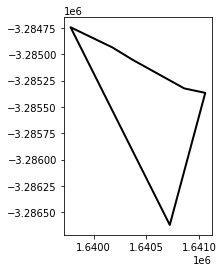

In [13]:
RamsarBoundary.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2);

<a id='CalculateDepthPerTime'></a>
## Calculate the water level for each inundated area across all time

TO DO: The code at the moment takes the `HeightPercentile` percentile of LiDAR heights intersected by a wet 'blob'. If the blob sits over a sloped relief, then the results are biased towards the higher part of the scene. This results in incorrectly deep water depths for these locations. FIX THIS.

We calculate the depth of water across the wetland at each Landsat timestep by combining the Landsat wet observations with a LiDAR DEM. For each time step, the discrete wet blobs are polygonised, so that we can get the outline of the water extent for each patch of wet area. Once we have this outline, we use it to sample the values from the underlying DEM. We take the `HeightPercentile` percentile of all of these sampled DEM values, and assume that this represent the height on the DEM to which water has filled. 

We then subtract this height from the DEM, and crop it back to just our small wet blob. This blob of water heights is then put back into a dataframe.

Note that if the value in the LiDAR DEM is higher than the calculated water height, then a nan is returned for that pixel.This may occur if there is noise in the LiDAR data, like a tree or bush, or if the course Landsat wet area includes areas of heigh relief, like a stream bank. 

### Create an empty data array to put our inundation results in to

In [14]:
WetlandWaterDepths = HighResLidar['DEM'].copy()
WetlandWaterDepths[:] = np.nan
WetlandWaterDepths = WetlandWaterDepths.expand_dims({'time': AllDataCombined.time}).copy()
# WetlandWaterDepths = WetlandWaterDepths.expand_dims({'time': AllDataCombined.time.isel(time=range(0,1))}).copy()

### Loop through each time step and calculate the water inundation height

Loop through all timesteps, then all individual wet blobs within that timestep. We want to treat each individual wet blob as separate from the rest of the scene, so that we can calculate a local water height. 

In [15]:
# Loop through each time step
for ix in range(0, len(WetlandWaterDepths.time)):
    # print out an update every 50 timesteps
    if ix/50 == int(ix/50):
        print(f'Working on {WetlandWaterDepths.time[ix].data}')
    # Interpolate the satellite data onto the grid of the Lidar
    WetonLidar = AllDataCombined['wet'].isel(time=ix).interp(x = HighResLidar.x, y= HighResLidar.y, method='nearest')
    # Convert to a boolean wet/not wet
    WetonLidar = np.isfinite(WetonLidar)
    # Check for a completely dry timestep. If it is completely dry, ignore it.
    if WetonLidar.sum() > 0:
        # Polygonize the wet bits in the timestep to turn them into polygons
        WetPolygons = features.shapes(WetonLidar.data.astype('float32'),
                                      transform=HighResLidar.attrs['transform'],
                                     connectivity=8)
        # Convert polygons into a geodataframe
        DiscreteWetPolygons = gpd.GeoDataFrame(WetPolygons, columns =['stringgeom', 'wetyes'])
        # Fix up the geometry attribute
        DiscreteWetPolygons['geometry'] = None
        for idx, poly in DiscreteWetPolygons.iterrows():
            DiscreteWetPolygons.loc[idx,'geometry'] = shapelyshape(poly[0])
        # Set the geometry of the dataframe to be the shapely geometry we just created
        DiscreteWetPolygons = DiscreteWetPolygons.set_geometry('geometry')
        # We need to add the crs back onto the dataframe
        DiscreteWetPolygons.crs = 'EPSG:3577'
        # Drop the nan polygon created from the nan values
        DiscreteWetPolygons = DiscreteWetPolygons.loc[DiscreteWetPolygons['wetyes'] == 1]
        # And drop the temporary stringgeom
        DiscreteWetPolygons.drop('stringgeom', axis=1, inplace=True)
        
        # Now loop through each polygon shape to calculate a water surface height
        for shapez in DiscreteWetPolygons.iterrows():
            # Sample the LiDAR array that intersects with the outline of each wet polygon
            # then create a 2D interpolated smooth surface from the DEM values to simulate water inundating it
            EstWaterLevel = get_water_level(shapez[1]['geometry'], HighResLidar.DEM, height_percentile = HeightPercentile)
            # Subtract 
            EstWaterHeight = EstWaterLevel['water_level'] - HighResLidar.DEM
            EstWaterHeight.attrs['transform'] = HighResLidar.attrs['transform']
            y, x = HighResLidar.DEM.values.shape
            # Now convert the polgons into a numpy array
            RasterWetPoly = features.rasterize(shapes=shapez[1],
                                                    out_shape=(y, x),
                                                    all_touched=False,
                                                    fill=np.nan,
                                                    transform=HighResLidar.attrs['transform'])
            # Convert result to a xarray.DataArray using coords etc from the LiDAR data
            RasterWetPoly = xr.DataArray(RasterWetPoly,
                                     coords=[HighResLidar.y, HighResLidar.x],
                                     dims=['y', 'x'],
                                     name='wetBits',
                                     attrs=HighResLidar.attrs)
            WaterBodyHeight = EstWaterHeight.where((RasterWetPoly == 1) & (EstWaterHeight >= 0))
            WetlandWaterDepths.loc[{'time': WetlandWaterDepths['time'][ix]}] = xr.where(np.isfinite(WaterBodyHeight), WaterBodyHeight, 
                                                                          WetlandWaterDepths.loc[{'time': WetlandWaterDepths['time'][ix]}])

Working on 1986-08-21T23:16:16.640546000
Working on 1989-09-14T23:20:42.106106000
Working on 1992-09-13T23:23:10.992894992
Working on 1994-07-17T23:19:07.580589008
Working on 1996-10-10T23:20:08.747154000
Working on 1998-12-03T23:40:00.995968016
Working on 2000-06-23T23:52:49.231301968
Working on 2002-03-18T23:43:39.253472016
Working on 2003-10-15T23:43:03.951326992
Working on 2004-11-02T23:43:45.582506000
Working on 2005-09-26T23:42:59.549638992
Working on 2006-11-07T23:55:25.343765968
Working on 2008-03-10T23:44:59.571389008
Working on 2009-04-30T23:42:21.388907984
Working on 2010-06-12T23:47:01.072137040
Working on 2011-09-18T23:49:30.620566992
Working on 2013-08-14T23:56:20.230874960
Working on 2014-08-26T00:01:08.381210064
Working on 2015-10-08T23:54:53.898777040
Working on 2017-03-27T00:00:40.127125968
Working on 2018-06-26T00:00:33.711983952
Working on 2019-08-08T23:42:21.260121040


### Write out to netCDF

In [11]:
WetlandWaterDepths.to_netcdf(WetlandWaterDepthsFileName)

### Compare the depth results with the Landsat wet obs

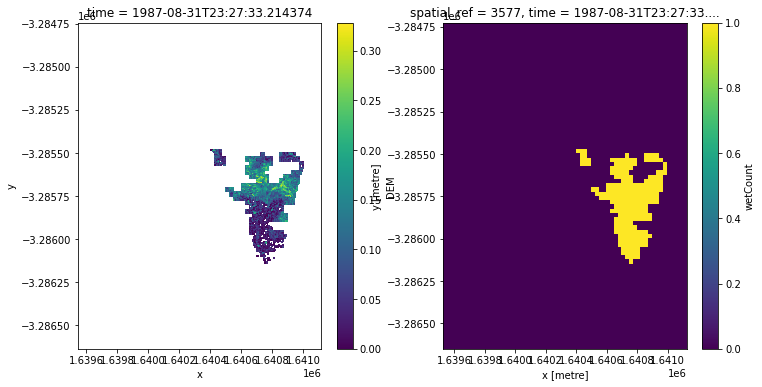

In [17]:
# Find a time where there was wet areas
wettime = 1

fig, ax = plt.subplots(1,2, figsize=[12, 6]);
WetlandWaterDepths.isel(time=wettime).plot(ax=ax[0]);
AllDataCombined['wetCount'].isel(time=wettime).plot(ax=ax[1]);

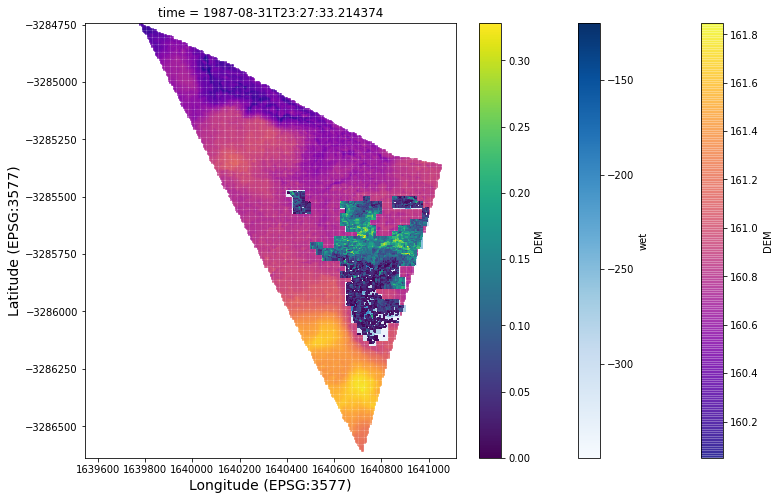

In [20]:
fig, ax = plt.subplots(1,1, figsize=[13, 8]);
HighResLidar.DEM.plot(cmap='plasma', alpha = 0.6);
AllDataCombined['wet'].isel(time=wettime).plot(cmap='Blues')
WetlandWaterDepths.isel(time=wettime).plot()
plt.ticklabel_format(useOffset=False, style='plain');
plt.xlabel('Longitude (EPSG:3577)', fontsize=14);
plt.ylabel('Latitude (EPSG:3577)', fontsize=14);

<a id='IdentifyEvents'></a>
## Identify 'events' within the wetland

Here an 'event' starts when `EventThreshold`% of the total wetland area seen as wet, and ends when no more than `EventThreshold`% of the wetland remains 'wet'. Additional steps to refine the definition of an event are applied. The process involves:
* Count the wet pixels across the whole wetland per time step, and find where at least `EventThreshold`% of the wetland is 'wet'
    * If a timestep is above the threshold, it will be 'True'/1
    * If a timestep is below the threshold, it will be 'False'/0
* Identify times when the wetland switches from above to below (or below to above) the threshold
    * This is done by subtracting each time step from the subsequent timestep
    * If it equals 1, then the array has moved from False to True
        * e.g. if timestep one is True, and timestep two is False, then timestep one minus timestep two = 1.
    * If it equals -1, then the array has moved from True to False
* Check whether the first obervation of the wetland was wet
    * If it was, we can't say for sure how long prior to the start of LS obs it was wet, so we throw this wet event out. If it wasn't wet then we don't need to worry. 
* Calculate the length (in days) of each event
* Find short events and see whether we can combine them with the previous or next event
    * Since we have Landsat 7 data in here, the SLC-off issue results in some scenes where < `EventThreshold`% of the wetland area is observed as wet, then when the next Landsat 8 scene comes in, it jumps back up over the threshold. We want to deal with these by seeing if another observation above the chosen `EventThreshold` occurs within `CloseEnoughTogether` days so that we can assume the event actually continues. 
    * TO DO: for now, this check is only applied to short events. We really should just check each event and see whether it can be joined to the previous or next event.
* Write the events out to csv

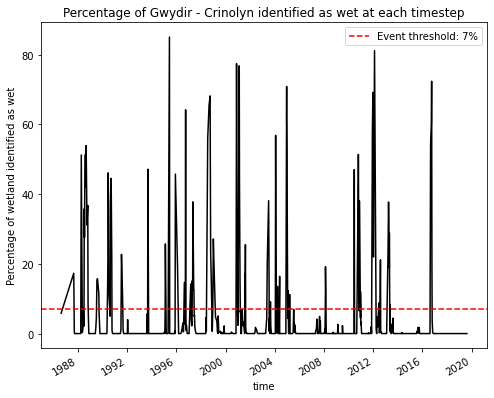

In [114]:
# See how much of the wetland is inundated at each time step
WetArea = (AllDataCombined['wetCount'].sum(dim=['x', 'y']) / (np.isfinite(AllDataCombined['TCW']).sum(dim=['x', 'y']))) * 100

WetArea.plot(figsize=([8,6]), color='k');
plt.axhline(EventThreshold, color='r', linestyle='--', label=f'Event threshold: {EventThreshold}%');
plt.ylabel('Percentage of wetland identified as wet');
plt.title(f'Percentage of {AnalysisLocation} identified as wet at each timestep');
plt.legend();
plt.savefig(WetEventsLinePlot, bbox_inches='tight');

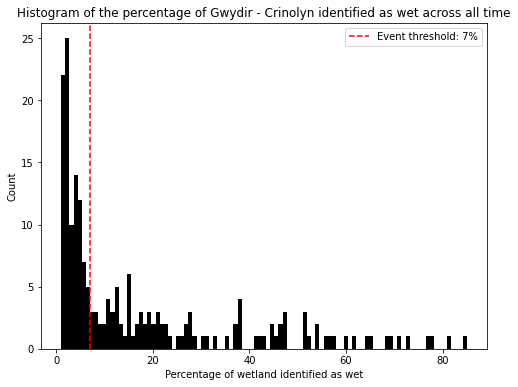

In [115]:
fig = plt.figure(figsize=([8,6]))
plt.hist(WetArea[WetArea > 1], bins = 99, color='k');
plt.axvline(EventThreshold, color='r', linestyle='--', label=f'Event threshold: {EventThreshold}%');
plt.ylabel('Count');
plt.xlabel('Percentage of wetland identified as wet');
plt.title(f'Histogram of the percentage of {AnalysisLocation} identified as wet across all time');
plt.legend();
plt.savefig(WetEventsHistogram, bbox_inches='tight');

In [88]:
# Count the wet pixels per time step, and find where at least `EventThreshold`% of the wetland is 'wet'
ThresholdBooleanPctTimestepWet = AllDataCombined['wetCount'].sum(dim=['x', 'y']
                                                                ) > (np.isfinite(AllDataCombined['TCW']).sum(dim=['x', 'y']
                                                                                                            ) / 100 * EventThreshold)

In [90]:
ThresholdBooleanPctTimestepWet

<xarray.DataArray (time: 1052)>
array([False,  True, False, ..., False, False, False])
Coordinates:
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 1986-08-21T23:16:16.640546 ... 2019-08-15T23:48:14.574313040

Find where the wetland switches above/below `EventThreshold`% inundation. We can do this by looking for changes in the boolean operators

In [91]:
# Subtract subsequent value from first value
Testforchange = ThresholdBooleanPctTimestepWet[1:].values.astype(int) - ThresholdBooleanPctTimestepWet[:-1].values.astype(int)
# if it equals 1, then the array has moved from False to True
StartofEvent = ThresholdBooleanPctTimestepWet[1:].where(Testforchange == 1).dropna(dim='time')
# if it equals -1, then the array has moved from True to False
EndofEvent = ThresholdBooleanPctTimestepWet[1:].where(Testforchange == -1).dropna(dim='time')

#### Check whether the wetland was wet when it was first observed (1986/7), and when it was last observed (most recent observation)

If the first time a wetland is observed by Landsat 5 (1986/7), the wetland meets the event threshold, we choose NOT to include this event in the list of events. We don't know for how long the wetland was wet before we first observed it, and so can't provide uncertainties on event duration, so we do not include it in the results.

If the wetland has been wet up until the most recent observation, we DO include this event, and for the sake of calculating the event duration, we set the most recent observation as the end date. This will change as the code is run over new data and eventually the event will be observed to end itself.

In [92]:
# We need to check whether the wetland is first observed during a wet event. 
# If it is, then the first value we actually find is an end date, which throws off our calculation.
if ThresholdBooleanPctTimestepWet[0] == 1:
    # Skip the first EndofEvent, since we didn't capture the start and so can't say 
    EndofEvent = EndofEvent[1:]

# Also need to check if we've captured the end of the event properly
# If the event ends with a wet observation, we wont capture this in the code below
# Because we know that time -1 of this event is the end of the wetland-wide event,
# we can just add time -1 as the last end date.
if ThresholdBooleanPctTimestepWet[-1] == 1:
    # Then the event wont 'end' since it wont have flipped
    EndofEvent = np.hstack((AnyPartWet[-1], EndofEvent))

Make use of pandas datetime operators to calculate the length of time between each start and end date. 

In [93]:
# Now calculate the length of time between the inundation events within the overall wetland event
# Code notation notes:
#`astype('timedelta64[D]')` converts the timedelta from `ns` to `days`. 
#`/ np.timedelta64(1, 'D')` removes the timedelta information and just returns the number of days as a float.
EventDuration = (EndofEvent.time.values - StartofEvent.time.values).astype('timedelta64[D]') / np.timedelta64(1, 'D')

Convert the results into a dataframe so we can export to csv

In [94]:
EventList = pd.DataFrame(EventDuration.astype(int),  
                         columns = ['days-in-event'])
EventList['event-start-date'] = StartofEvent.time.dt.strftime('%Y-%m-%d').values.astype(str)
EventList['event-end-date'] = EndofEvent.time.dt.strftime('%Y-%m-%d').values.astype(str)
EventList

,days-in-event,event-start-date,event-end-date
0,8,1987-08-31,1987-09-09
1,32,1988-04-11,1988-05-13
2,16,1988-06-07,1988-06-23
3,135,1988-07-09,1988-11-21
4,63,1989-07-19,1989-09-21
5,79,1990-05-28,1990-08-16
6,47,1990-08-23,1990-10-10
7,48,1991-07-18,1991-09-04
8,23,1993-09-09,1993-10-02
9,24,1995-02-10,1995-03-07


### Find events < `ShortEventThreshold` days and double check it's not just a single scene that has dropped below the threshold

Since we have Landsat 7 data in here, the SLC-off issue results in some scenes where < `EventThreshold`% of the wetland area is observed as wet, then when the next Landsat 8 scene comes in, it jumps back up over the threshold. This results in some very short 'events'. 

We want to check whether this is the case, and combine any events that have been identified that occur within `CloseEnoughTogether` days of previous or subsequent events.

In [39]:
# Create an index list of rows to drop
RowsToDrop = []
# Find events that are less than 30 days long
ShortEvent = EventList['days-in-event'] < ShortEventThreshold
# Get the indices of these short events
ShortEventIndex = EventList.index[ShortEvent == True].tolist()
# Note that we are not going to loop through the last index
# We will check the last index when we check the second last one
for idxshortevent, shortevent in enumerate(ShortEventIndex):
    # Set our flags back to false
    previousMerge = False
    nextMerge = False
    # First test: is this part of a series of consecutive small events we need to combine?
    try:
        if ShortEventIndex[idxshortevent + 1] - ShortEventIndex[idxshortevent] == 1 and (pd.to_datetime(EventList.loc[shortevent +1]['event-start-date']) - 
         pd.to_datetime(EventList.loc[shortevent]['event-end-date'])).days <= CloseEnoughTogether:
            # If the consecutive events are less than 16 days apart, we need to treat them as one event
            # with the start date of the first event, but the end date of the second
            Starts = pd.to_datetime(EventList.loc[shortevent]['event-start-date'])
            Ends = pd.to_datetime(EventList.loc[shortevent + 1]['event-end-date'])
            # We've combined two events, so the next event is now shortevent + 2
            nextindex = shortevent + 2
            # We're merging this event with the next, so flag that we have modified both
            RowsToDrop.append(shortevent + 1)
            RowsToDrop.append(shortevent)
        else:
            # Otherwise we just use the single event start and end dates
            Starts = pd.to_datetime(EventList.loc[shortevent]['event-start-date'])
            Ends = pd.to_datetime(EventList.loc[shortevent]['event-end-date'])
            # We're only using one event, so the next event is now shortevent + 1
            nextindex = shortevent + 1
    except IndexError:
        # This means we are at the last value in the list, so value + 1 is out of range
        # So we just treat this event as a single event. If it's part of an earlier consecutive event
        # It will be captured by that earlier index as the next value
        Starts = pd.to_datetime(EventList.loc[shortevent]['event-start-date'])
        Ends = pd.to_datetime(EventList.loc[shortevent]['event-end-date'])
        # We're only using one event, so the next event is now shortevent + 1
        nextindex = shortevent + 1
    # Now work out whether we can merge our event with the next event
    # Did this event start within 16 days of the previous event?
    if (Starts - pd.to_datetime(EventList.loc[shortevent -1]['event-end-date'])).days <= CloseEnoughTogether:
        previousMerge = True
        # We'll merge with the previous event, so flag it to be dropped
        RowsToDrop.append(shortevent -1)
        RowsToDrop.append(shortevent)
    # Did this event finish within 16 days of the next event?
    if (pd.to_datetime(EventList.loc[nextindex]['event-start-date']) - Ends).days <= CloseEnoughTogether:
        nextMerge = True
        # We'll merge with the next event, so flag it to be dropped
        RowsToDrop.append(nextindex)
        RowsToDrop.append(shortevent)
    # So lets work out what we need to merge
    if previousMerge and nextMerge:
        EventStart = pd.to_datetime(EventList.loc[shortevent -1]['event-start-date'])
        EventEnd = pd.to_datetime(EventList.loc[nextindex]['event-end-date'])
        EventDuration = (EventEnd - EventStart).days
        EventList = EventList.append(pd.Series({'days-in-event': EventDuration,
                         'event-start-date': EventStart.strftime('%Y-%m-%d'),
                         'event-end-date': EventEnd.strftime('%Y-%m-%d')},name=shortevent*1000))
    if previousMerge and not nextMerge:
        EventStart = pd.to_datetime(EventList.loc[shortevent -1]['event-start-date'])
        EventEnd = Ends
        EventDuration = (EventEnd - EventStart).days
        EventList = EventList.append(pd.Series({'days-in-event': EventDuration,
                         'event-start-date': EventStart.strftime('%Y-%m-%d'),
                         'event-end-date': EventEnd.strftime('%Y-%m-%d')},name=shortevent*1000))
    if nextMerge and not previousMerge:
        EventStart = Starts
        EventEnd = pd.to_datetime(EventList.loc[nextindex]['event-end-date'])
        EventDuration = (EventEnd - EventStart).days
        EventList = EventList.append(pd.Series({'days-in-event': EventDuration,
                         'event-start-date': EventStart.strftime('%Y-%m-%d'),
                         'event-end-date': EventEnd.strftime('%Y-%m-%d')},name=shortevent*1000))
        
# Now drop all the rows we have modified
EventList.drop(set(RowsToDrop), inplace=True)
# Drop any duplicate entried
EventList.drop_duplicates(inplace=True)
# And sort again by date, resetting the index
EventList.sort_values('event-start-date', ignore_index=True, inplace=True)

### Finally, we want to get rid of any remaining events less than `ShortEventThreshold` long

In [111]:
EventList = EventList[EventList['days-in-event'] >=30].reset_index()
EventList

,index,days-in-event,event-start-date,event-end-date
0,1,32,1988-04-11,1988-05-13
1,3,135,1988-07-09,1988-11-21
2,4,63,1989-07-19,1989-09-21
3,5,79,1990-05-28,1990-08-16
4,6,47,1990-08-23,1990-10-10
5,7,48,1991-07-18,1991-09-04
6,11,96,1995-12-04,1996-03-09
7,15,56,1997-04-20,1997-06-16
8,16,135,1998-07-21,1998-12-03
9,17,80,1998-12-19,1999-03-09


In [112]:
EventList.to_csv(EventListFileName, index=False)

<a id='InundationDuration'></a>
## Calculate the per event pixel inundation duration

Here, the analysis is done on a per event basis. This means that we assume that if a single pixels wets, dries, wets etc more than once, it's all related to the same wetland-wide event (which is defined above). 

The code below loops through each species type within the wetland, and calculates the percentage of that species' area that is inundated for more than 30, 90, 150, 210 and 270 days during the whole event. If a single pixel records a wetting history of e.g. 5 days wet, then is dry for 5 days, then wet for 45 days, then we consider this pixel to have been wet for 50 days during this event. 

The results for each vegetation community during each event is written out as a pickle file for use later on.

In [98]:
# Loop through all the vegetation communities
for items in SpeciesDict:
    print(f'Working on {SpeciesDict[items]}')
    # Loop through all the individual wetting events
    for ix, row in EventList.iterrows():
        print(f'Working on event starting {row["event-start-date"]}')
        # Grab just the wet pixels that intersect with our veg type (boolean)
        JustOneVegTypeWet = AllDataCombined['wetCount'].where(AllDataCombined['veg_randomUID'] == items)
        # Grab just the time slices that coincide with the event we're now analysing
        EventData = JustOneVegTypeWet.loc[slice(row['event-start-date'], row['event-end-date'])]
        # Make an empty array to put the event results in to
        EventResults = np.empty((len(AllDataCombined.y), len(AllDataCombined.x)))
        EventResults[:] = np.nan
        # Now loop through each pixel and work out how long it was inundated for during the event
        for x in range(len(EventData.x)):
            for y in range(len(EventData.y)):
                pixelArray=EventData[:,y,x]
                # test whether this pixel is just all NaN - if it is, we don't need to analyse it
                if pixelArray.sum() > 0:
                    # Subtract subsequent value from first value
                    Testforchange = pixelArray[1:].values.astype(int) - pixelArray[:-1].values.astype(int)
                    # if it equals 1, then the array has moved from False to True
                    StartofEvent = pixelArray[:-1].where(Testforchange == 1).dropna(dim='time')
                    # if it equals -1, then the array has moved from True to False
                    EndofEvent = pixelArray[1:].where(Testforchange == -1).dropna(dim='time')
                    # We need to check whether we've captured the start of the event properly
                    # If the event starts as wet at time zero, we wont capture this in the code below
                    # Because we know that time 0 of this event is the start of the wetland-wide event,
                    # we can just add time 0 as the first start date.
                    if pixelArray[0] == 1:
                        # Grab the first time step of the event and add it to the StartofEvent array
                        StartofEvent = np.hstack((pixelArray.time.values[0], StartofEvent.time.values))
                    else:
                        # If not, just change the format of the StartofEvent variable to match the changed one
                        StartofEvent = StartofEvent.time.values
                    # Also need to check if we've captured the end of the event properly
                    # If the event ends with a wet observation, we wont capture this in the code below
                    # Because we know that time -1 of this event is the end of the wetland-wide event,
                    # we can just add time -1 as the last end date.
                    if pixelArray[-1] == 1:
                        # Then the event wont 'end' since it wont have flipped
                        EndofEvent = np.hstack((pixelArray.time.values[-1], EndofEvent.time.values))
                    else:
                        # If not, just change the format of the EndofEvent variable to match the changed one
                        EndofEvent = EndofEvent.time.values
                    # Now calculate the length of time between the inundation events within the overall wetland event
                    EventDuration = (EndofEvent - StartofEvent).astype('timedelta64[D]') / np.timedelta64(1, 'D')
                    # Sum the total inundation time
                    EventResults[y,x] = EventDuration.sum()

        # Save out the individual event results as well
        with open(f'{EventResultsPickleFileName}{row["event-start-date"]}_{SpeciesDict[items].replace(" ", "").replace("/", "")}_{items}_{AnalysisLocation.replace(" ", "").replace("/", "")}.pkl','wb') as f:
            pickle.dump(EventResults, f)

Working on Aquatic grass / sedge / forb
Working on event starting 1988-04-11
Working on event starting 1988-07-09
Working on event starting 1989-07-19
Working on event starting 1990-05-28
Working on event starting 1990-08-23
Working on event starting 1991-07-18
Working on event starting 1995-12-04
Working on event starting 1997-04-20
Working on event starting 1998-07-21
Working on event starting 1998-12-19
Working on event starting 2000-11-23
Working on event starting 2001-02-11
Working on event starting 2003-05-15
Working on event starting 2004-12-19
Working on event starting 2010-11-18
Working on event starting 2011-12-08
Working on event starting 2013-03-16
Working on event starting 2016-08-31
Working on Coolibah open grassy / chenopod grassy woodland
Working on event starting 1988-04-11
Working on event starting 1988-07-09
Working on event starting 1989-07-19
Working on event starting 1990-05-28
Working on event starting 1990-08-23
Working on event starting 1991-07-18
Working on ev

### Plot event-based counts of vegetation community inundation

<a id='InundationExtent'></a>
## 1. Maps of inundation extent across the time period 2014-2019

**to start, annual max inundation for 2014-2020**

Inundation extent for each month across the time period. (This could be presented so that you can slide along a hydrograph and see the resultant inundation extent on a map below. This should also identify key vegetation types). These maps should also include key vegetation types, including open water

## 2. Maps of inundation extent for each vegetation type for each event 

An event comprises the time between commencement of inundation of the vegetation type and conclusion of inundation of the vegetation type i.e. vegetation type completely dry. Sort by events for critical durations: 1, 3, 5, 7, > 9 months.

In [45]:
for ix, row in EventList.iterrows():
    EventFileList = glob.glob(f'{EventResultsPickleFileName}{row["event-start-date"]}*')
    EventResults = np.empty((len(AllDataCombined.y), len(AllDataCombined.x)))
    EventResults[:] = np.nan 
    for files in EventFileList:
        with open(files,'rb') as f:
            eventresults = pickle.load(f)
            EventResults = np.where(np.isnan(EventResults), eventresults, EventResults)
    fig, ax = plt.subplots(1,1, figsize=[12, 10]);
    RamsarBoundary.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2, ax=ax);
    AxLocation = 0.17;
    fig.subplots_adjust(right=0.8);
    for ix, items in enumerate(SpeciesDict):
        PlotData = EventResults.copy();
        PlotData[AllDataCombined['veg_randomUID'] != items] = np.nan;
        h = ax.pcolormesh(AllDataCombined.x, AllDataCombined.y, PlotData, cmap=Colormaps[ix], vmin=0, vmax=np.nanmax(EventResults));
        AxLocation = AxLocation + 0.15;
        # add_axes([left, bottom, width, height])
        cbar_ax = fig.add_axes([0.85, AxLocation, 0.2, 0.05]);
        fig.colorbar(h, cax=cbar_ax, label=SpeciesDict[items], orientation='horizontal');
    ax.ticklabel_format(useOffset=False, style='plain');
    ax.set_ylabel('Latitude (EPSG:3577)', fontsize=14);
    ax.set_xlabel('Longitude (EPSG:3577)', fontsize=14);
    ax.set_title(f'Number of days each pixel was wet during {AnalysisLocation} {row["days-in-event"]} day event starting {row["event-start-date"]}', 
                 fontsize=16, fontweight='bold');
    fig.savefig(f'{EventMapsFileName}{row["event-start-date"]}', 
                bbox_inches='tight');
    fig.clear();

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

### Re-plot the last iteration here to show what the plots look like

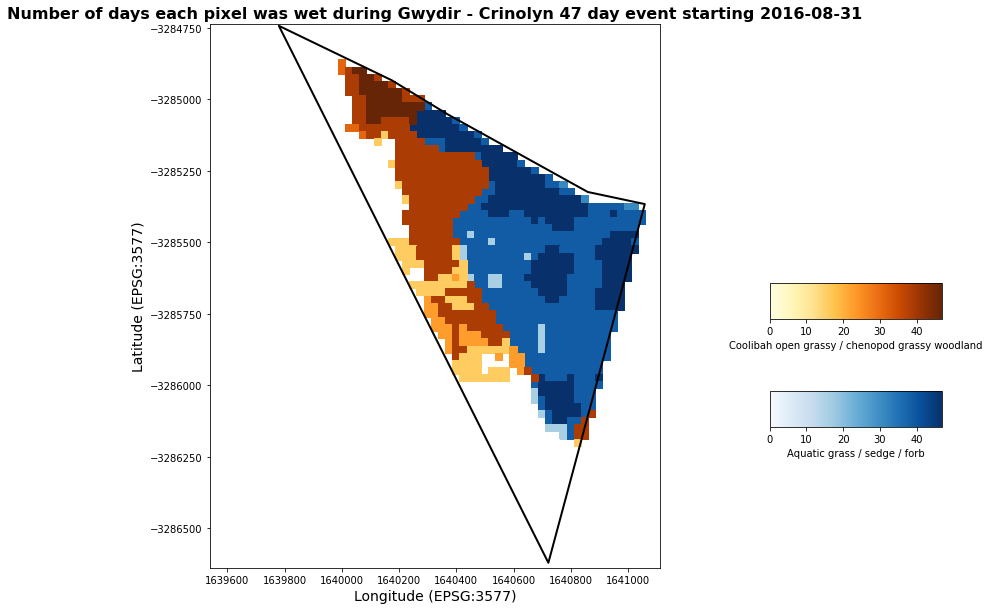

In [101]:
fig, ax = plt.subplots(1,1, figsize=[12, 10]);
RamsarBoundary.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2, ax=ax);
AxLocation = 0.17;
fig.subplots_adjust(right=0.8);
for ix, items in enumerate(SpeciesDict):
    PlotData = EventResults.copy();
    PlotData[AllDataCombined['veg_randomUID'] != items] = np.nan;
    h = ax.pcolormesh(AllDataCombined.x, AllDataCombined.y, PlotData, cmap=Colormaps[ix], vmin=0, vmax=np.nanmax(EventResults));
    AxLocation = AxLocation + 0.15;
    # add_axes([left, bottom, width, height])
    cbar_ax = fig.add_axes([0.85, AxLocation, 0.2, 0.05]);
    fig.colorbar(h, cax=cbar_ax, label=SpeciesDict[items], orientation='horizontal');
ax.ticklabel_format(useOffset=False, style='plain');
ax.set_ylabel('Latitude (EPSG:3577)', fontsize=14);
ax.set_xlabel('Longitude (EPSG:3577)', fontsize=14);
ax.set_title(f'Number of days each pixel was wet during {AnalysisLocation} {row["days-in-event"]} day event starting {row["event-start-date"]}', 
             fontsize=16, fontweight='bold');

### 2.a. Comparison of remotely sensed data maps with ground-truthed data and OEH datasets 

(NSW only)

## 3. Maps of depth for critical durations

Only if DEM data is available within GA or supplied by CEWO (1, 3, 5, 7, >9 months)

## 4. Vegetation condition over the entire four year period

## 5. Graph and .csv file of inundation duration for each different vegetation type
For all natural and environmental flows

### Read in the relevant stream gauge

Convert the timestamp to a pandas datetime object

In [102]:
# Read in the relevant streamgauge data
StreamGaugeData = pd.read_csv(StreamGaugeToLoad, parse_dates=True, comment='#')
# Turn the Timestamp into a padas dateime object
StreamGaugeData['Timestamp'] = pd.to_datetime(StreamGaugeData['Timestamp'])

### Calculate the percentage of each vegetation community inundated across all time

# We also want to know how big an area each vegetation community covers to put the percentages into perspective

In [103]:
# Create a dataframe to put our results into, starting with the time
InundationPctPerVeg = pd.DataFrame({'Date': AllDataCombined.time})
# Make the time the index for the dataframe
InundationPctPerVeg.set_index('Date', inplace=True)

# Loop through all the vegetation communities
for items in SpeciesDict:
    # Grab just the pixels containing our veg community
    WetVeg = AllDataCombined['wetCount'].where(AllDataCombined['veg_randomUID'] == items)
    # Count the number of wet observations per time step
    WetVegCount = WetVeg.sum(dim=['x', 'y'])
    # Convert the count to a percentage of the total community that's wet
    WetVegPct = (WetVegCount / (AllDataCombined['veg_randomUID'] == items).sum()) * 100
    InundationPctPerVeg[SpeciesDict[items]] = WetVegPct

### Save the results to csv, and plot against the stream gauge

In [104]:
InundationPctPerVeg.to_csv(InundationPctPerVegDataFileName)

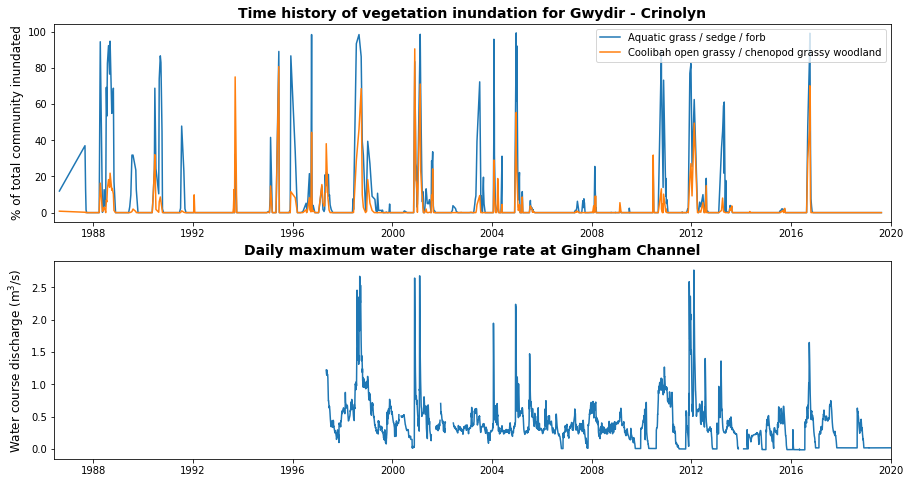

In [105]:
fig, axes = plt.subplots(2,1, figsize=(15,8));
axes[0].plot(InundationPctPerVeg);
axes[0].legend(InundationPctPerVeg.columns.values)
axes[0].set_ylabel(f'% of total community inundated', fontsize = 12);
axes[0].set_title(f'Time history of vegetation inundation for {AnalysisLocation}', fontsize = 14, fontweight = 'bold');
axes[0].set_xlim([pd.to_datetime('1986-6-1'), pd.to_datetime('2020-1-1')]);

axes[1].plot(StreamGaugeData['Timestamp'], StreamGaugeData['Value']);
axes[1].set_ylabel('Water course discharge (m$^3$/s)', fontsize = 12);
axes[1].set_title(f'Daily maximum water discharge rate at {StreamGaugeName}', fontsize = 14, fontweight = 'bold');
axes[1].set_xlim([pd.to_datetime('1986-6-1'), pd.to_datetime('2020-1-1')]);

plt.savefig(InundationPctPerVegFigFileName, bbox_inches='tight')

## 6. Table identifying: 
* % of different vegetation classes inundated for each specified time period for each event and maximum and average depth of inundation.

e.g. 

| Site | Sub-site | Event | Vegetation Type | % inundated 1 month | % inundated 3 months | % inundated 5 months | % inundated 7 months | % inundated > 9 months | Max depth | Average depth |
|-----|----|----|----|----|----|----|----|----|----|----|

* Time between each inundation event for 10%, 25%, 50%, 75% and 100% of each vegetation type 

e.g.

| Site | Sub-site | Event | Vegetation Type | 10% veg inundation duration | 25% veg inundation duration | 50% veg inundation duration | 75% veg inundation duration | 100% veg inundation duration | Max depth | Average depth |
|-----|----|----|----|----|----|----|----|----|----|----|

### Calculate within event inundation metrics

We need to set up two dataframes to put the results into

In [106]:
# Create a dataframe to put our results into, starting with the time
EventInundationTable = pd.concat([EventList]*len(SpeciesDict)).sort_values(by='event-start-date', ignore_index=True)
EventInundationTable['vegType'] = list(SpeciesDict.values())* len(EventList)
EventInundationTable['PctInundated>=30days'] = np.nan
EventInundationTable['PctInundated>=90days'] = np.nan
EventInundationTable['PctInundated>=150days'] = np.nan
EventInundationTable['PctInundated>=210days'] = np.nan
EventInundationTable['PctInundated>=270days'] = np.nan

In [107]:
EventInundationTable.head(2)

,days-in-event,event-start-date,event-end-date,vegType,PctInundated>=30days,PctInundated>=90days,PctInundated>=150days,PctInundated>=210days,PctInundated>=270days
0,32,1988-04-11,1988-05-13,Aquatic grass / sedge / forb,NaN,NaN,NaN,NaN,NaN
1,32,1988-04-11,1988-05-13,Coolibah open grassy / chenopod grassy woodland,NaN,NaN,NaN,NaN,NaN


In [108]:
# Create a dataframe to put our results into, starting with the time
EventDurationTable = pd.concat([EventList]*len(SpeciesDict)).sort_values(by='event-start-date', ignore_index=True)
EventDurationTable['vegType'] = list(SpeciesDict.values())* len(EventList)
EventDurationTable['AtLeast10PctInundated'] = np.nan
EventDurationTable['AtLeast25PctInundated'] = np.nan
EventDurationTable['AtLeast50PctInundated'] = np.nan
EventDurationTable['AtLeast75PctInundated'] = np.nan
EventDurationTable['100PctInundated'] = np.nan

In [109]:
EventDurationTable.head(2)

,days-in-event,event-start-date,event-end-date,vegType,AtLeast10PctInundated,AtLeast25PctInundated,AtLeast50PctInundated,AtLeast75PctInundated,100PctInundated
0,32,1988-04-11,1988-05-13,Aquatic grass / sedge / forb,NaN,NaN,NaN,NaN,NaN
1,32,1988-04-11,1988-05-13,Coolibah open grassy / chenopod grassy woodland,NaN,NaN,NaN,NaN,NaN


### Now calculate the % inundation and duration of each vegetation category per event

Metrics for wet percentage for the 30, 90, 150, 210 and 270 day periods are calculated using >= each period. For example, a pixel that was wet for 110 days during an event will be counted in the 30 and 90 day metrics, but not the 150 day metric. 

The second step in the analysis calculates how long at least 10/25/50/75/100% of the wetland vegetation community was inundated per event. We sort all of the values for each pixel in each event, and then use indexing to find the value at each percentage category. E.g.

```
EventResults = [0, 0, 6, 9, 4, 3, 0, 1, 1, 0]
TotalArraySize = len(EventResults)
SortedResults = [0, 0, 0, 0, 1, 1, 3, 4, 6, 9]
SortedResults = SortedResults[::-1] #reverse the order to descending
# Find the index of the value at 50% of the array ( - 1 due to zero indexing)
Indexat50PctArea = int(TotalArraySize * 0.5) -1
# The value in the sorted array at this index tells us how many days at least 50% of the veg area was wet for
AtLeast50PctofArray = SortedResults[Indexat50PctArea]
    >> 1
```

In [110]:
filelist = glob.glob(f'{EventResultsPickleFileName}*')
for files in filelist:
    with open(files,'rb') as f:
        EventResults = pickle.load(f)
    pathstartdate, vegname, items, analysisloc = files.split('_')
    pathbits = pathstartdate.split('/')
    startdate = pathbits[-1]
    # Now write out the inundation area percentage thresholds
    # Get the index of the row we need to put the results into
    indexofrow = EventInundationTable.loc[(EventInundationTable['event-start-date'] == startdate) 
                         & (EventInundationTable['vegType'] == SpeciesDict[int(items)])].index.item()
    # In the next lines, we are looking for locations in the results where values are >= some number
    # Since we have nans in the array, the code throws a warning
    # The behaviour of the comparison is correct for what we want, i.e. (NaN >= 30) = False
    # So we can suppress these warnings to clear up the output of this cell
    with np.errstate(invalid='ignore'):
        # Calculate the percent of each vegetation community inundated for the various lengths of time
        # Save out the results to one decimal place
        EventInundationTable.at[indexofrow,'PctInundated>=30days'] = round((((EventResults >=30).sum() / 
                                                                      (AllDataCombined['veg_randomUID'] == int(items)).sum().item()) * 100), 1)
        EventInundationTable.at[indexofrow,'PctInundated>=90days'] = round((((EventResults >=90).sum() / 
                                                                      (AllDataCombined['veg_randomUID'] == int(items)).sum().item()) * 100), 1)
        EventInundationTable.at[indexofrow,'PctInundated>=150days'] = round((((EventResults >=150).sum() / 
                                                                       (AllDataCombined['veg_randomUID'] == int(items)).sum().item()) * 100), 1)
        EventInundationTable.at[indexofrow,'PctInundated>=210days'] = round((((EventResults >=210).sum() / 
                                                                       (AllDataCombined['veg_randomUID'] == int(items)).sum().item()) * 100), 1)
        EventInundationTable.at[indexofrow,'PctInundated>=270days'] = round((((EventResults >=270).sum() / 
                                                                       (AllDataCombined['veg_randomUID'] == int(items)).sum().item()) * 100), 1)
    # Now write out the inundation duration percentage thresholds
    # Get the index of the row we need to put the results into
    indexofrow = EventDurationTable.loc[(EventDurationTable['event-start-date'] == startdate) 
                         & (EventDurationTable['vegType'] == SpeciesDict[int(items)])].index.item()
    # Create a mask for the full extent of the vegetation category
    VegMask = AllDataCombined['veg_randomUID'] == int(items)
    # Work out the total number of pixels taken up by the veg category
    VegTotalArea = VegMask.sum().item()
    # Convert all the nans in the EventResults to zero
    # This is because we want to know where a veg pixel was not seen as wet at all
    InfilledEventResults = np.nan_to_num(EventResults)
    # Remove the zeros from EventResults that are not covered by the veg category
    InfilledEventResults[~VegMask] = np.nan
    # Flatten the results - we don't need them to be spatial anymore
    AllFiniteValues = InfilledEventResults.flatten()
    # Remove all the nans - they're outside the area of interest
    AllFiniteValues = AllFiniteValues[~np.isnan(AllFiniteValues)]
    # Sort the array
    AllFiniteValuesSorted = np.sort(AllFiniteValues)
    # Reverse the order
    AllFiniteValuesSorted = AllFiniteValuesSorted[::-1]
    # Find the value in the sorted array that cuts off 10/25/50/75/100% of the array
    # Subtract one from the index due to zero indexing
    EventDurationTable.at[indexofrow,'AtLeast10PctInundated'] = round(AllFiniteValuesSorted[int(VegTotalArea * AreasToCalc[0] -1)], 1)
    EventDurationTable.at[indexofrow,'AtLeast25PctInundated'] = round(AllFiniteValuesSorted[int(VegTotalArea * AreasToCalc[1] -1)], 1)
    EventDurationTable.at[indexofrow,'AtLeast50PctInundated'] = round(AllFiniteValuesSorted[int(VegTotalArea * AreasToCalc[2] -1)], 1)
    EventDurationTable.at[indexofrow,'AtLeast75PctInundated'] = round(AllFiniteValuesSorted[int(VegTotalArea * AreasToCalc[3] -1)], 1)
    # 100% of the array is the last value, so just grab that
    EventDurationTable.at[indexofrow,'100PctInundated'] = round(AllFiniteValuesSorted[VegTotalArea * AreasToCalc[4] -1], 1)

    # Save the final tables to file
    EventInundationTable.to_csv(EventInundationTableFileName, index=False)
    EventDurationTable.to_csv(EventDurationTableFileName, index=False)

## 7. Annual vegetation condition for each Ramsar site for the whole archive period